In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
import requests
import glob
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import os
import re
from scipy.stats import pearsonr

### 데이터 전처리

In [3]:
# 파일 불러오고, 결합
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')
df_list = [pd.read_csv(file, encoding='euc-kr') for file in file_list]
forecast_df = pd.concat(df_list, ignore_index=True)

In [4]:
forecast_df['일시'] = pd.to_datetime(forecast_df['일시'])
forecast_df.head()

# '일시'에서 날짜만 추출 / '지점'과 "날짜"별로 그룹화 / 각 그룹별 평균 계산
forecast_df['날짜'] = forecast_df['일시'].dt.date  # 날짜만 추출
grouped = forecast_df.groupby(['지점', '날짜'])
daily_avg = grouped.mean().reset_index()
# daily_avg
#----------------이하 위치별 dataframe---------------
#부안
df_buan = daily_avg[daily_avg['지점'] ==22186]
# df_buan

#가거도
df_gageodo = daily_avg[daily_avg['지점'].isin([22297, 22193])]
# df_gageodo

#마라도
df_marado = daily_avg[daily_avg['지점'] ==22107]
# df_marado

#통영
df_tongyoung = daily_avg[daily_avg['지점'] ==22188]
# df_tongyoung

#동해
df_donghae = daily_avg[daily_avg['지점'].isin([22105, 22305, 22302])]
df_donghae_combined = df_donghae.groupby('날짜').mean(numeric_only=True).reset_index()
df_donghae_combined['지점'] = 22105

# df_donghae_combined

In [36]:
df_buan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3145 entries, 7165 to 10309
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   지점           3145 non-null   int64         
 1   날짜           3145 non-null   object        
 2   일시           3145 non-null   datetime64[ns]
 3   풍속(m/s)      3138 non-null   float64       
 4   풍향(deg)      3138 non-null   float64       
 5   GUST풍속(m/s)  3055 non-null   float64       
 6   현지기압(hPa)    3134 non-null   float64       
 7   습도(%)        3089 non-null   float64       
 8   기온(°C)       3113 non-null   float64       
 9   수온(°C)       3139 non-null   float64       
 10  최대파고(m)      3144 non-null   float64       
 11  유의파고(m)      3144 non-null   float64       
 12  평균파고(m)      3140 non-null   float64       
 13  파주기(sec)     3144 non-null   float64       
 14  파향(deg)      3144 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
m

### 이하 위 데이터프레임 시각화

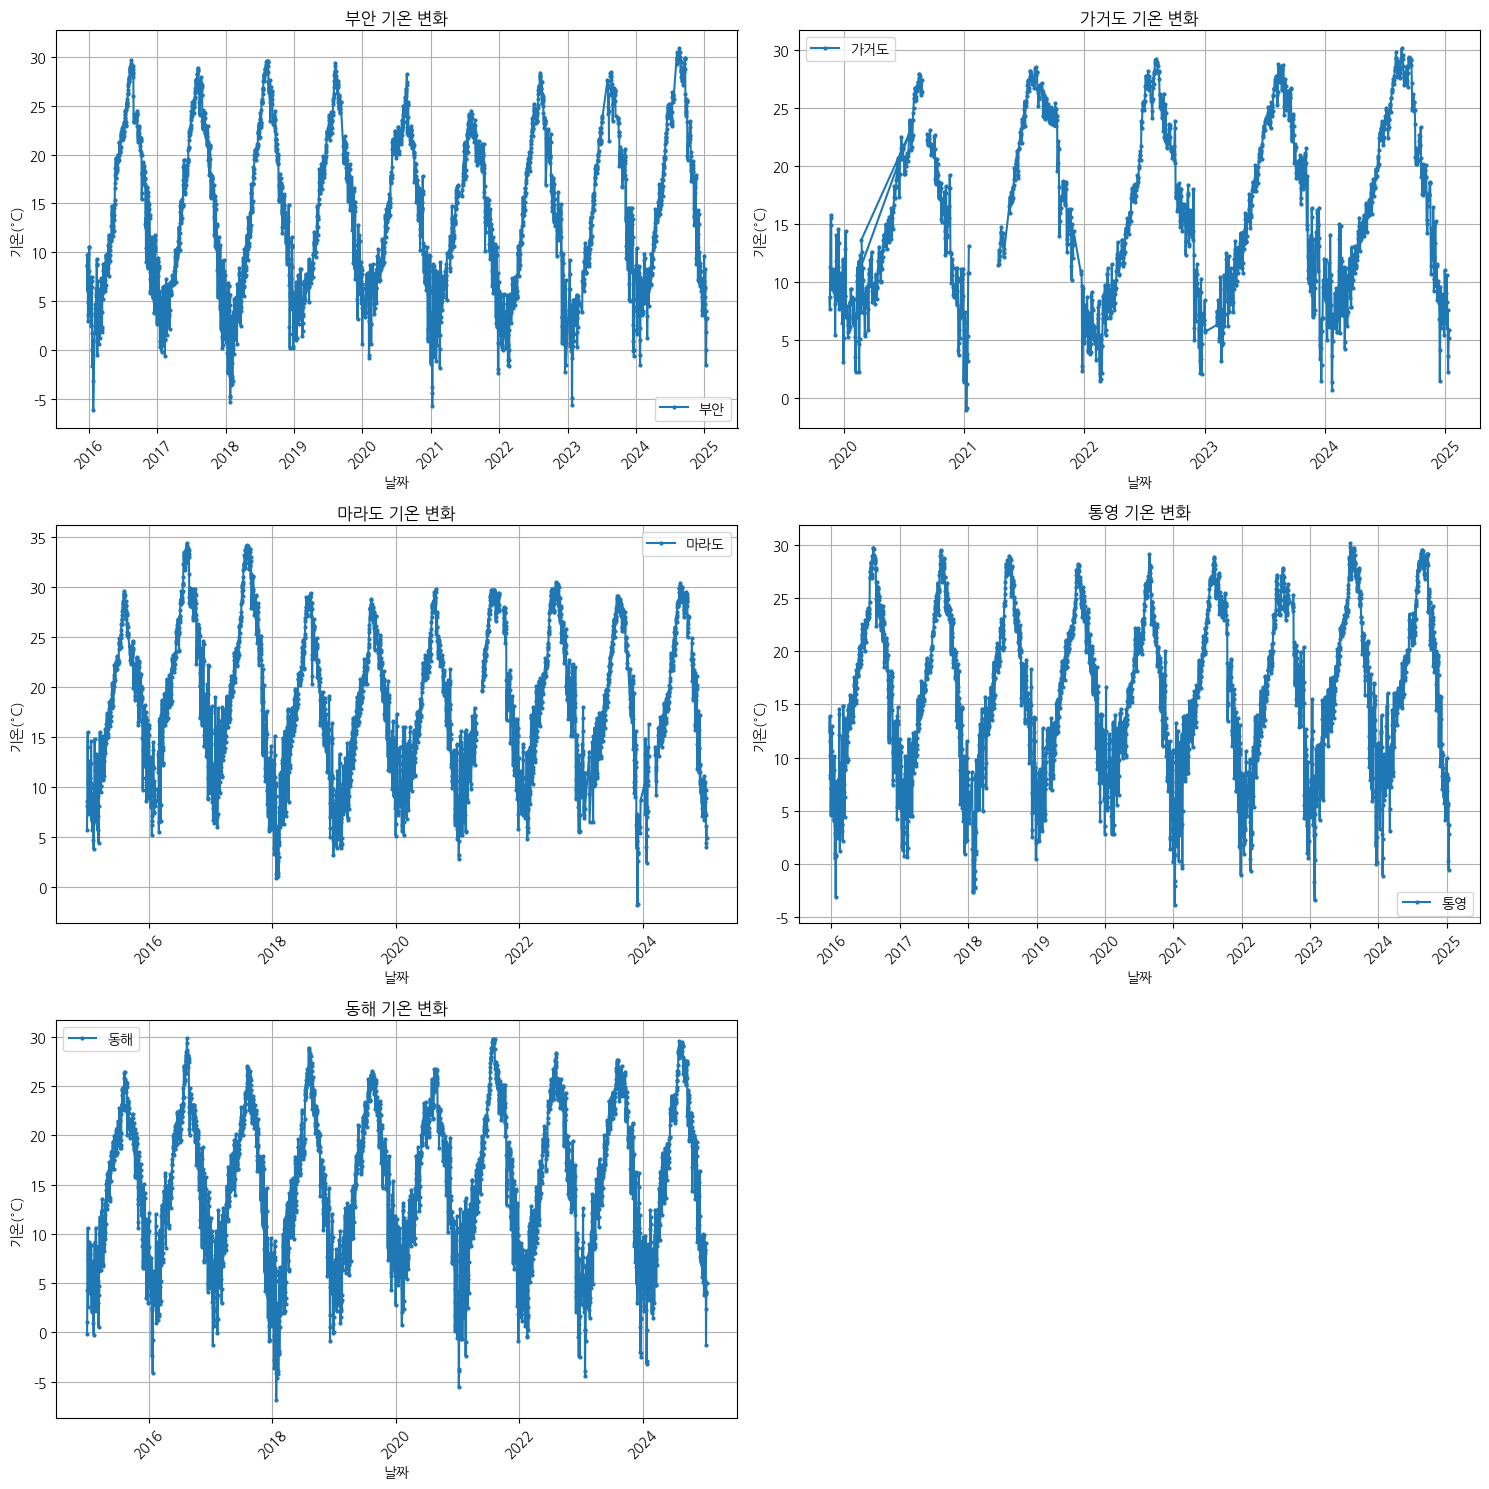

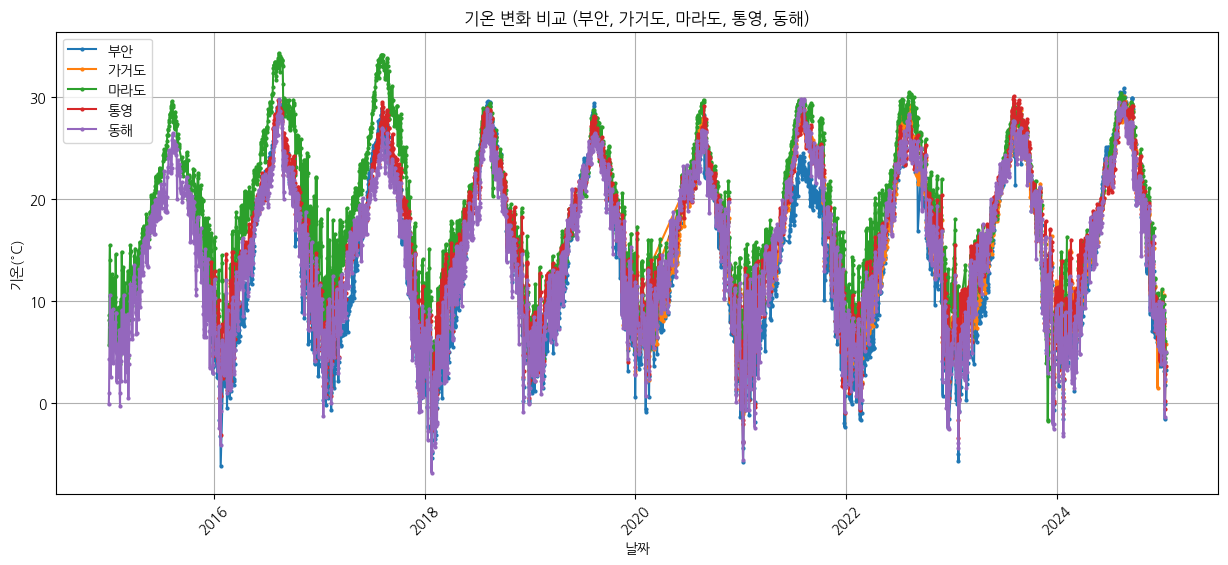

In [6]:
dfs = [df_buan, df_gageodo, df_marado, df_tongyoung, df_donghae_combined]
labels = ['부안', '가거도', '마라도', '통영', '동해']

# 1. 서브플롯: 각각 별도의 차트에 시각화
plt.figure(figsize=(15, 15))  # 서브플롯 크기 설정
for i, (df, label) in enumerate(zip(dfs, labels), start=1):
    plt.subplot(3, 2, i)  # 3행 2열 형태의 서브플롯
    plt.plot(df['날짜'], df['기온(°C)'], label=label, marker='o', markersize=2)
    plt.title(f'{label} 기온 변화')
    plt.xlabel('날짜')
    plt.ylabel('기온(°C)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
for df, label in zip(dfs, labels):
    plt.plot(df['날짜'], df['기온(°C)'], label=label, marker='o', markersize=2)

plt.title('기온 변화 비교 (부안, 가거도, 마라도, 통영, 동해)')
plt.xlabel('날짜')
plt.ylabel('기온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

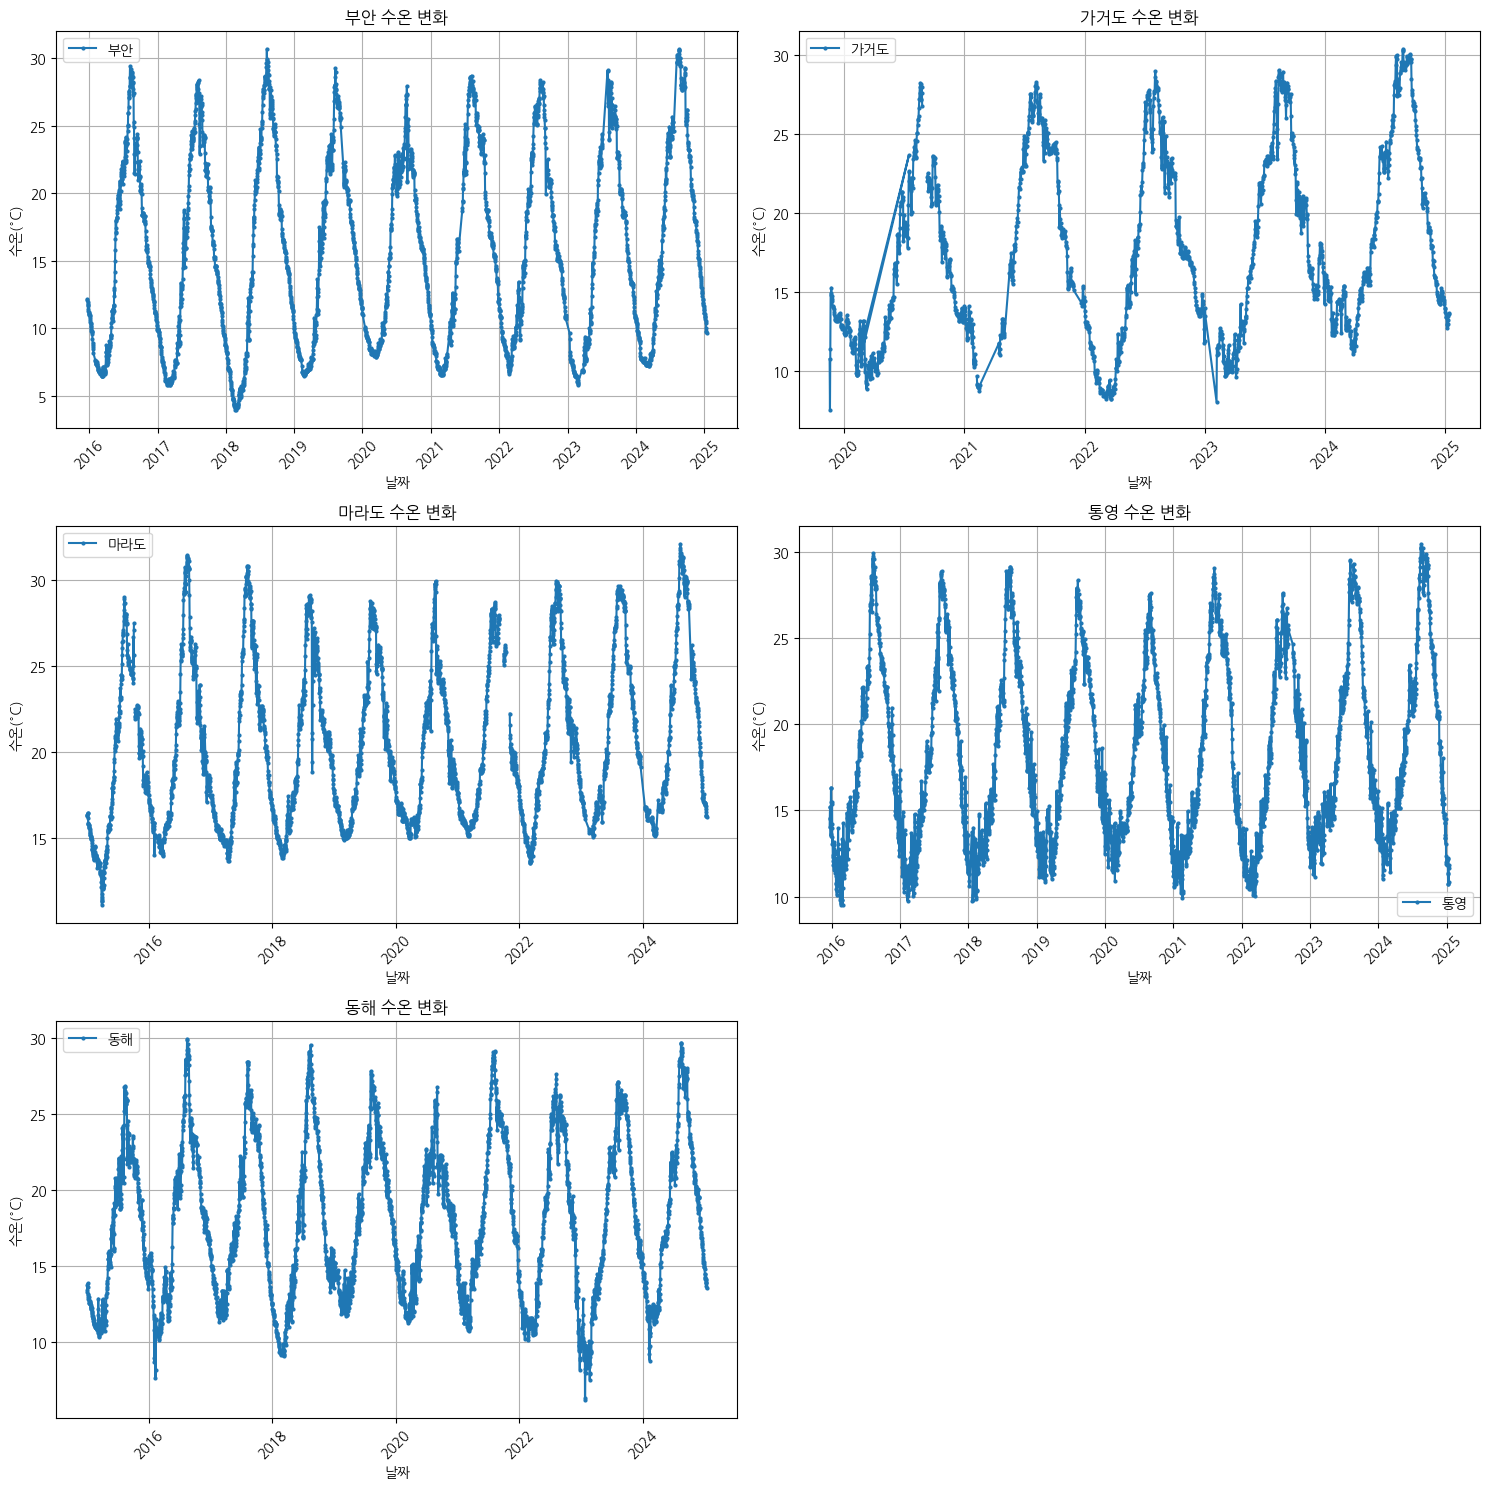

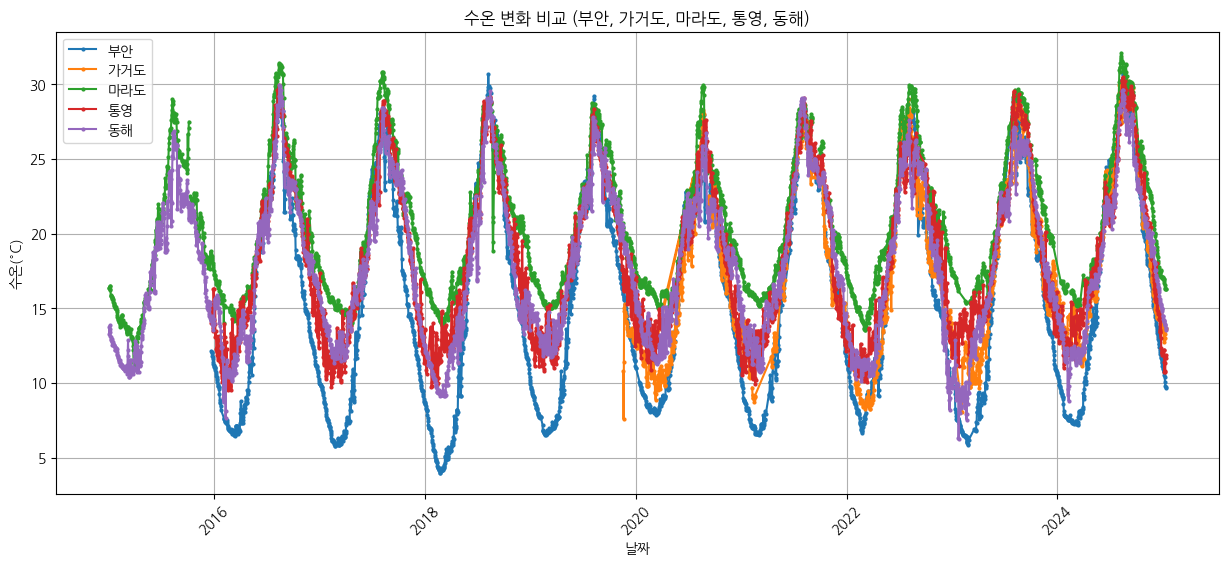

In [7]:
dfs = [df_buan, df_gageodo, df_marado, df_tongyoung, df_donghae_combined]
labels = ['부안', '가거도', '마라도', '통영', '동해']

# 1. 서브플롯: 각각 별도의 차트에 시각화
plt.figure(figsize=(15, 15))  # 서브플롯 크기 설정
for i, (df, label) in enumerate(zip(dfs, labels), start=1):
    plt.subplot(3, 2, i)  # 3행 2열 형태의 서브플롯
    plt.plot(df['날짜'], df['수온(°C)'], label=label, marker='o', markersize=2)
    plt.title(f'{label} 수온 변화')
    plt.xlabel('날짜')
    plt.ylabel('수온(°C)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
for df, label in zip(dfs, labels):
    plt.plot(df['날짜'], df['수온(°C)'], label=label, marker='o', markersize=2)

plt.title('수온 변화 비교 (부안, 가거도, 마라도, 통영, 동해)')
plt.xlabel('날짜')
plt.ylabel('수온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [74]:
redtide= "../data/raw/적조데이터.csv"
df = pd.read_csv(redtide, encoding='utf-8-sig')
df = df.drop(columns=['좌표'])  
df.head()

,예찰일자,발생해역,적조생물,밀도(개체수/mL),수온,염분
0,2024-09-10,-,없음,0~0,26~30.2,31.1~32.7
1,2024-09-09,-,없음,0~0,26.1~29.7,30.7~32.7
2,2024-09-08,-,없음,0~0,26.2~28.6,30.8~32.6
3,2024-09-07,-,없음,0~0,25.1~29.1,30.1~32.6
4,2024-09-06,-,없음,0~0,25.5~29.1,31~32.6


In [75]:
# 수온과 염분의 중간값을 계산하는 함수
def calculate_mid_value(range_str):
    try:
        # 값이 float으로 저장된 경우 문자열로 변환
        range_str = str(range_str)

        # '~' 구분자로 값 나누기
        if '~' in range_str:
            lower, upper = map(float, range_str.split('~'))
            return (lower + upper) / 2
        else:
            return float(range_str)  # 범위가 아니라 단일 값이 있을 경우 처리
    except ValueError:
        return None  # 데이터가 비정상적일 경우 None 반환

# 컬럼을 문자열로 변환 (오류 방지)
df['수온'] = df['수온'].astype(str)
df['염분'] = df['염분'].astype(str)

# '수온(C)'과 '염분' 컬럼에 중간값 적용
df['수온'] = df['수온'].apply(calculate_mid_value)
df['염분'] = df['염분'].apply(calculate_mid_value)

df.head()

,예찰일자,발생해역,적조생물,밀도(개체수/mL),수온,염분
0,2024-09-10,-,없음,0~0,28.1,31.90
1,2024-09-09,-,없음,0~0,27.9,31.70
2,2024-09-08,-,없음,0~0,27.4,31.70
3,2024-09-07,-,없음,0~0,27.1,31.35
4,2024-09-06,-,없음,0~0,27.3,31.80


In [52]:
# 데이터 로드 및 전처리 (예제 데이터)
algal_bloom = pd.read_csv('../data/raw/적조데이터.csv', encoding='utf-8-sig')
algal_bloom['예찰일자'] = pd.to_datetime(algal_bloom['예찰일자'])
algal_bloom['발생여부'] = 1  # 적조 발생 이벤트 표시
algal_bloom.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   예찰일자        767 non-null    datetime64[ns]
 1   발생해역        755 non-null    object        
 2   적조생물        767 non-null    object        
 3   밀도(개체수/mL)  656 non-null    object        
 4   수온(C)       751 non-null    object        
 5   염분          744 non-null    object        
 6   좌표          503 non-null    object        
 7   발생여부        767 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 48.1+ KB


In [53]:
algal_bloom.head()

,예찰일자,발생해역,적조생물,밀도(개체수/mL),수온(C),염분,좌표,발생여부
0,2024-09-10,-,없음,0~0,26~30.2,31.1~32.7,NaN,1
1,2024-09-09,-,없음,0~0,26.1~29.7,30.7~32.7,NaN,1
2,2024-09-08,-,없음,0~0,26.2~28.6,30.8~32.6,NaN,1
3,2024-09-07,-,없음,0~0,25.1~29.1,30.1~32.6,NaN,1
4,2024-09-06,-,없음,0~0,25.5~29.1,31~32.6,NaN,1


In [101]:
# 파일 로드
price_data = pd.read_csv('../data/prep/item_price_filled_pivot.csv', encoding='utf-8-sig')
price_data['date'] = pd.to_datetime(price_data['priceDate'])
price_data.drop(columns=['priceDate'], inplace=True)
forecast_data = pd.read_csv('../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_data['date'] = pd.to_datetime(forecast_data['일시'])
forecast_data.drop(columns=['일시'], inplace=True)

# 날짜 기준 데이터 병합
merged_df = pd.merge(price_data, forecast_data, left_on='date', right_on='date', how='inner')

# 이하 대게 금액&기상 비교 / 데이터 누락 행 제거
target_cols = [col for col in forecast_data.columns if col not in ['date']]
df_comparison = merged_df[['대게_avgPrice'] + target_cols].dropna()

# 스케일링링
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_comparison)
df_scaled

# 1. 피어슨 상관계수 계산
pearson_corr = {col: pearsonr(df_comparison['대게_avgPrice'], df_comparison[col])[0] for col in target_cols}
pearson_corr

array([[-1.70701704, -1.20408222,  0.08743079, ...,  0.31872921,
        -0.2173785 ,  0.61859411],
       [-1.70701704, -1.20408222,  0.18040631, ..., -0.49043899,
        -0.80916116, -0.57223866],
       [-1.70701704, -1.20408222,  2.63401459, ...,  2.86674822,
         1.58262711,  0.9742974 ],
       ...,
       [ 1.97987192,  0.09965269,  0.75244215, ...,  1.58126115,
         1.49221587,  0.1612613 ],
       [ 1.97987192,  1.78037119,  0.36950907, ..., -0.24941017,
        -0.27491292, -0.24525675],
       [ 1.97987192,  1.85890943,  2.11555786, ...,  1.57552237,
         1.3442702 ,  1.28581395]], shape=(179952, 12))

In [ ]:
# 이하 확인해봐야 함

# 2. 코사인 유사도 계산
cos_sim = cosine_similarity(df_scaled[:, :1], df_scaled[:, 1:])

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1 while Y.shape[1] == 11

In [102]:
# 유사도 분석



# 2. 코사인 유사도 계산
cos_sim = cosine_similarity(df_scaled[:, 0].reshape(-1, 1), df_scaled[:, 1:])

# 결과 출력
print("피어슨 상관계수 결과:", pearson_corr)
print("코사인 유사도 결과:", cos_sim.mean())


plt.figure(figsize=(10, 5))
plt.plot(df_comparison['대게_avgPrice'], label='대게 가격', color='blue')
for col in target_cols:
    plt.plot(df_comparison[col], label=col, linestyle='--')
plt.legend()
plt.title("대게 가격과 예측 데이터 비교")
plt.show()

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1 while Y.shape[1] == 11